## Continual learning on the MNIST incremental learning task


In [1]:
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.nn import functional as F
#from torch import nn
from torch import autograd

from include import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


### Get training and test data loaders for incremental MNIST

In [2]:
batch_size = 512

import torchvision.transforms as T
train_data = datasets.MNIST(root = './data', train = True,
                        transform = T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x/255.))]),#transforms.ToTensor(),
                            download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x/255.))]) #transform = transforms.ToTensor()
                          )

def get_indices(dataset,classes):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in classes:
            indices.append(i)
    return indices

train_loaders = []
test_loaders = []
pairs = [ [0,1],[2,3],[4,5],[6,7],[8,9] ]

for pair in pairs:
    idx = get_indices(train_data, pair)
    train_loaders += [torch.utils.data.DataLoader(train_data,batch_size=batch_size, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))]
    idx = get_indices(test_data, pair)
    test_loaders += [torch.utils.data.DataLoader(test_data,batch_size=batch_size, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))]

In [27]:
train_loaders_all = []
test_loaders_all = []
pairs = [ [0,1],[0,1,2,3],[0,1,2,3,4,5],[0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7,8,9] ]

for pair in pairs:
    idx = get_indices(train_data, pair)
    train_loaders_all += [torch.utils.data.DataLoader(train_data,batch_size=batch_size, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))]
    idx = get_indices(test_data, pair)
    test_loaders_all += [torch.utils.data.DataLoader(test_data,batch_size=batch_size, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))]

## Code to evaluate the EWC variants, and training on all the data

In [51]:
def train_model(model,train_gen,ewc,num_epochs=20):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD( model.parameters(), lr=lr)    
    for epoch in range(num_epochs):
        for i ,(images,labels) in enumerate(train_gen):
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
    
            optimizer.zero_grad()
            outputs = model(images)
            
            loss_function = nn.MSELoss()
            labels = torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float32)
            loss = loss_function(outputs, labels)
            #if i==0 and epoch==0:
            #    print("std:",loss.data)
            loss += ewc.loss(model)
            #if i==0 and epoch==0:
            #    print("ewc:",loss.data)
            loss.backward()
            optimizer.step()
    
            if i == 0: #and epoch == num_epochs - 1:
                print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))


def test_model(model,test_gen):
    correct = 0
    total = 0
    for images,labels in test_gen:
        images = Variable(images).cuda()
        labels = labels.cuda()
  
        output = model(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
    #return ((100.0*correct)/(total+1))
    return ((100.0*correct)/(total))

In [43]:
def run_simulation(net,train_loader,test_loader,ewc,num_epochs=20):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    individual_errors = []
    for k in range(num_tasks): 
        
        # train model
        train_model(net,train_loader[k],ewc,num_epochs=num_epochs)
        # compute Hessian before updating
        if ewc.lam>0 and k < num_tasks-1:
            #ewc.compute_data( net,train_loader[k] )
            ewc.update( net,train_loader[k] )

        inderrors = []
        for i in range(k+1):
            erri = test_model(net,test_loader[i])
            inderrors += [erri.cpu().numpy()]
            res[k] += erri / (k+1)
        print("test performance : ", res)
        print("individual errors: ", inderrors)
        individual_errors += [inderrors]
    return res,individual_errors




def train_model_plain(model,train_gen,num_epochs=20):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        for i ,(images,labels) in enumerate(train_gen):
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
    
            optimizer.zero_grad()
            outputs = model(images)
            
            loss_function = nn.MSELoss()
            labels = torch.nn.functional.one_hot(labels,num_classes=10).to(torch.float32)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i == 0: #and epoch == num_epochs - 1:
                print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))

def train_on_all(net,train_loader,test_loader,num_epochs=20):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    for k in range(num_tasks):
        ### get new model
        net = get_random_feature_model()
        train_model_plain(net, train_loader[k] ,num_epochs=num_epochs)
        res[k] = test_model(net,test_loader[k])
        print("test performance : ", res)
    return res

# Random feature model

In [8]:
class Net(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
  
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def get_random_feature_model(input_size = 784,hidden_size = 4*784,num_classes = 10):
    net = Net(input_size, hidden_size, num_classes).cuda()
    for param in net.fc1.parameters():
        param.requires_grad = False
    return net

In [9]:
num_epochs = 60
lr = 1e-1 # size of step

In [10]:
results = []
inderrors = []
ss = [50,100,200,400,800,1600,3200]
for s in ss:
    res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-5,s=s),num_epochs=num_epochs )
    results += [res]
    inderrors += [inds]

EWC++  50 1e-05
Epoch [1/60], Loss: 0.1025
Epoch [2/60], Loss: 0.1506
Epoch [3/60], Loss: 0.0640
Epoch [4/60], Loss: 0.0357
Epoch [5/60], Loss: 0.0291
Epoch [6/60], Loss: 0.0245
Epoch [7/60], Loss: 0.0188
Epoch [8/60], Loss: 0.0163
Epoch [9/60], Loss: 0.0126
Epoch [10/60], Loss: 0.0106
Epoch [11/60], Loss: 0.0094
Epoch [12/60], Loss: 0.0076
Epoch [13/60], Loss: 0.0060
Epoch [14/60], Loss: 0.0062
Epoch [15/60], Loss: 0.0054
Epoch [16/60], Loss: 0.0056
Epoch [17/60], Loss: 0.0051
Epoch [18/60], Loss: 0.0042
Epoch [19/60], Loss: 0.0048
Epoch [20/60], Loss: 0.0043
Epoch [21/60], Loss: 0.0050
Epoch [22/60], Loss: 0.0045
Epoch [23/60], Loss: 0.0040
Epoch [24/60], Loss: 0.0044
Epoch [25/60], Loss: 0.0041
Epoch [26/60], Loss: 0.0039
Epoch [27/60], Loss: 0.0041
Epoch [28/60], Loss: 0.0044
Epoch [29/60], Loss: 0.0039
Epoch [30/60], Loss: 0.0038
Epoch [31/60], Loss: 0.0039
Epoch [32/60], Loss: 0.0044
Epoch [33/60], Loss: 0.0043
Epoch [34/60], Loss: 0.0037
Epoch [35/60], Loss: 0.0035
Epoch [36/60]

Epoch [12/60], Loss: 0.1122
Epoch [13/60], Loss: 0.1100
Epoch [14/60], Loss: 0.1076
Epoch [15/60], Loss: 0.1066
Epoch [16/60], Loss: 0.1054
Epoch [17/60], Loss: 0.1037
Epoch [18/60], Loss: 0.1016
Epoch [19/60], Loss: 0.0988
Epoch [20/60], Loss: 0.1001
Epoch [21/60], Loss: 0.0960
Epoch [22/60], Loss: 0.0957
Epoch [23/60], Loss: 0.0941
Epoch [24/60], Loss: 0.0914
Epoch [25/60], Loss: 0.0926
Epoch [26/60], Loss: 0.0921
Epoch [27/60], Loss: 0.0880
Epoch [28/60], Loss: 0.0879
Epoch [29/60], Loss: 0.0858
Epoch [30/60], Loss: 0.0851
Epoch [31/60], Loss: 0.0828
Epoch [32/60], Loss: 0.0832
Epoch [33/60], Loss: 0.0805
Epoch [34/60], Loss: 0.0814
Epoch [35/60], Loss: 0.0786
Epoch [36/60], Loss: 0.0791
Epoch [37/60], Loss: 0.0779
Epoch [38/60], Loss: 0.0748
Epoch [39/60], Loss: 0.0734
Epoch [40/60], Loss: 0.0729
Epoch [41/60], Loss: 0.0722
Epoch [42/60], Loss: 0.0704
Epoch [43/60], Loss: 0.0730
Epoch [44/60], Loss: 0.0685
Epoch [45/60], Loss: 0.0660
Epoch [46/60], Loss: 0.0692
Epoch [47/60], Loss:

Epoch [26/60], Loss: 0.0746
Epoch [27/60], Loss: 0.0748
Epoch [28/60], Loss: 0.0715
Epoch [29/60], Loss: 0.0700
Epoch [30/60], Loss: 0.0701
Epoch [31/60], Loss: 0.0657
Epoch [32/60], Loss: 0.0665
Epoch [33/60], Loss: 0.0636
Epoch [34/60], Loss: 0.0636
Epoch [35/60], Loss: 0.0612
Epoch [36/60], Loss: 0.0602
Epoch [37/60], Loss: 0.0583
Epoch [38/60], Loss: 0.0580
Epoch [39/60], Loss: 0.0553
Epoch [40/60], Loss: 0.0542
Epoch [41/60], Loss: 0.0556
Epoch [42/60], Loss: 0.0558
Epoch [43/60], Loss: 0.0501
Epoch [44/60], Loss: 0.0528
Epoch [45/60], Loss: 0.0503
Epoch [46/60], Loss: 0.0482
Epoch [47/60], Loss: 0.0489
Epoch [48/60], Loss: 0.0467
Epoch [49/60], Loss: 0.0458
Epoch [50/60], Loss: 0.0470
Epoch [51/60], Loss: 0.0449
Epoch [52/60], Loss: 0.0463
Epoch [53/60], Loss: 0.0424
Epoch [54/60], Loss: 0.0428
Epoch [55/60], Loss: 0.0415
Epoch [56/60], Loss: 0.0423
Epoch [57/60], Loss: 0.0392
Epoch [58/60], Loss: 0.0397
Epoch [59/60], Loss: 0.0406
Epoch [60/60], Loss: 0.0379
update data..
task d

Epoch [39/60], Loss: 0.0569
Epoch [40/60], Loss: 0.0571
Epoch [41/60], Loss: 0.0571
Epoch [42/60], Loss: 0.0567
Epoch [43/60], Loss: 0.0557
Epoch [44/60], Loss: 0.0564
Epoch [45/60], Loss: 0.0548
Epoch [46/60], Loss: 0.0529
Epoch [47/60], Loss: 0.0522
Epoch [48/60], Loss: 0.0510
Epoch [49/60], Loss: 0.0517
Epoch [50/60], Loss: 0.0515
Epoch [51/60], Loss: 0.0506
Epoch [52/60], Loss: 0.0497
Epoch [53/60], Loss: 0.0510
Epoch [54/60], Loss: 0.0477
Epoch [55/60], Loss: 0.0474
Epoch [56/60], Loss: 0.0460
Epoch [57/60], Loss: 0.0474
Epoch [58/60], Loss: 0.0462
Epoch [59/60], Loss: 0.0441
Epoch [60/60], Loss: 0.0458
update data..
task data norm and number entries: tensor(429.2043, device='cuda:0') torch.Size([200, 31370])
..done
test performance :  [99.95272064 95.41950989 90.93862152  0.          0.        ]
individual errors:  [array(97.16312, dtype=float32), array(87.65916, dtype=float32), array(87.99359, dtype=float32)]
Epoch [1/60], Loss: 0.1436
Epoch [2/60], Loss: 0.1597
Epoch [3/60], Lo

Epoch [51/60], Loss: 0.0328
Epoch [52/60], Loss: 0.0292
Epoch [53/60], Loss: 0.0296
Epoch [54/60], Loss: 0.0298
Epoch [55/60], Loss: 0.0310
Epoch [56/60], Loss: 0.0280
Epoch [57/60], Loss: 0.0322
Epoch [58/60], Loss: 0.0304
Epoch [59/60], Loss: 0.0289
Epoch [60/60], Loss: 0.0302
update data..
task data norm and number entries: tensor(448.5618, device='cuda:0') torch.Size([400, 31370])
..done
test performance :  [99.95272064 95.04800415  0.          0.          0.        ]
individual errors:  [array(97.58865, dtype=float32), array(92.50735, dtype=float32)]
Epoch [1/60], Loss: 0.1512
Epoch [2/60], Loss: 1.7023
Epoch [3/60], Loss: 0.2934
Epoch [4/60], Loss: 0.1288
Epoch [5/60], Loss: 0.1194
Epoch [6/60], Loss: 0.1166
Epoch [7/60], Loss: 0.1148
Epoch [8/60], Loss: 0.1140
Epoch [9/60], Loss: 0.1113
Epoch [10/60], Loss: 0.1079
Epoch [11/60], Loss: 0.1060
Epoch [12/60], Loss: 0.1042
Epoch [13/60], Loss: 0.1008
Epoch [14/60], Loss: 0.0972
Epoch [15/60], Loss: 0.0963
Epoch [16/60], Loss: 0.0921

task data norm and number entries: tensor(459.0760, device='cuda:0') torch.Size([800, 31370])
..done
test performance :  [99.81087494  0.          0.          0.          0.        ]
individual errors:  [array(99.810875, dtype=float32)]
Epoch [1/60], Loss: 0.1563
Epoch [2/60], Loss: 0.2859
Epoch [3/60], Loss: 0.1873
Epoch [4/60], Loss: 0.1099
Epoch [5/60], Loss: 0.1041
Epoch [6/60], Loss: 0.1001
Epoch [7/60], Loss: 0.0962
Epoch [8/60], Loss: 0.0925
Epoch [9/60], Loss: 0.0887
Epoch [10/60], Loss: 0.0858
Epoch [11/60], Loss: 0.0833
Epoch [12/60], Loss: 0.0794
Epoch [13/60], Loss: 0.0739
Epoch [14/60], Loss: 0.0714
Epoch [15/60], Loss: 0.0691
Epoch [16/60], Loss: 0.0651
Epoch [17/60], Loss: 0.0640
Epoch [18/60], Loss: 0.0611
Epoch [19/60], Loss: 0.0576
Epoch [20/60], Loss: 0.0577
Epoch [21/60], Loss: 0.0543
Epoch [22/60], Loss: 0.0522
Epoch [23/60], Loss: 0.0523
Epoch [24/60], Loss: 0.0484
Epoch [25/60], Loss: 0.0468
Epoch [26/60], Loss: 0.0482
Epoch [27/60], Loss: 0.0492
Epoch [28/60], L

Epoch [3/60], Loss: 0.0603
Epoch [4/60], Loss: 0.0333
Epoch [5/60], Loss: 0.0270
Epoch [6/60], Loss: 0.0214
Epoch [7/60], Loss: 0.0182
Epoch [8/60], Loss: 0.0142
Epoch [9/60], Loss: 0.0113
Epoch [10/60], Loss: 0.0088
Epoch [11/60], Loss: 0.0075
Epoch [12/60], Loss: 0.0077
Epoch [13/60], Loss: 0.0055
Epoch [14/60], Loss: 0.0053
Epoch [15/60], Loss: 0.0045
Epoch [16/60], Loss: 0.0052
Epoch [17/60], Loss: 0.0046
Epoch [18/60], Loss: 0.0041
Epoch [19/60], Loss: 0.0047
Epoch [20/60], Loss: 0.0045
Epoch [21/60], Loss: 0.0044
Epoch [22/60], Loss: 0.0043
Epoch [23/60], Loss: 0.0043
Epoch [24/60], Loss: 0.0037
Epoch [25/60], Loss: 0.0040
Epoch [26/60], Loss: 0.0040
Epoch [27/60], Loss: 0.0040
Epoch [28/60], Loss: 0.0036
Epoch [29/60], Loss: 0.0040
Epoch [30/60], Loss: 0.0036
Epoch [31/60], Loss: 0.0037
Epoch [32/60], Loss: 0.0031
Epoch [33/60], Loss: 0.0035
Epoch [34/60], Loss: 0.0030
Epoch [35/60], Loss: 0.0034
Epoch [36/60], Loss: 0.0035
Epoch [37/60], Loss: 0.0030
Epoch [38/60], Loss: 0.0036

Epoch [14/60], Loss: 0.1101
Epoch [15/60], Loss: 0.1091
Epoch [16/60], Loss: 0.1086
Epoch [17/60], Loss: 0.1061
Epoch [18/60], Loss: 0.1063
Epoch [19/60], Loss: 0.1040
Epoch [20/60], Loss: 0.1030
Epoch [21/60], Loss: 0.1031
Epoch [22/60], Loss: 0.1016
Epoch [23/60], Loss: 0.1028
Epoch [24/60], Loss: 0.1007
Epoch [25/60], Loss: 0.0999
Epoch [26/60], Loss: 0.0982
Epoch [27/60], Loss: 0.0974
Epoch [28/60], Loss: 0.0982
Epoch [29/60], Loss: 0.0954
Epoch [30/60], Loss: 0.0957
Epoch [31/60], Loss: 0.0964
Epoch [32/60], Loss: 0.0946
Epoch [33/60], Loss: 0.0946
Epoch [34/60], Loss: 0.0929
Epoch [35/60], Loss: 0.0920
Epoch [36/60], Loss: 0.0928
Epoch [37/60], Loss: 0.0966
Epoch [38/60], Loss: 0.0927
Epoch [39/60], Loss: 0.0907
Epoch [40/60], Loss: 0.0898
Epoch [41/60], Loss: 0.0905
Epoch [42/60], Loss: 0.0886
Epoch [43/60], Loss: 0.0890
Epoch [44/60], Loss: 0.0894
Epoch [45/60], Loss: 0.0876
Epoch [46/60], Loss: 0.0872
Epoch [47/60], Loss: 0.0863
Epoch [48/60], Loss: 0.0878
Epoch [49/60], Loss:

Epoch [28/60], Loss: 0.0713
Epoch [29/60], Loss: 0.0710
Epoch [30/60], Loss: 0.0697
Epoch [31/60], Loss: 0.0695
Epoch [32/60], Loss: 0.0685
Epoch [33/60], Loss: 0.0683
Epoch [34/60], Loss: 0.0676
Epoch [35/60], Loss: 0.0673
Epoch [36/60], Loss: 0.0656
Epoch [37/60], Loss: 0.0655
Epoch [38/60], Loss: 0.0657
Epoch [39/60], Loss: 0.0633
Epoch [40/60], Loss: 0.0656
Epoch [41/60], Loss: 0.0634
Epoch [42/60], Loss: 0.0614
Epoch [43/60], Loss: 0.0617
Epoch [44/60], Loss: 0.0601
Epoch [45/60], Loss: 0.0614
Epoch [46/60], Loss: 0.0604
Epoch [47/60], Loss: 0.0616
Epoch [48/60], Loss: 0.0601
Epoch [49/60], Loss: 0.0601
Epoch [50/60], Loss: 0.0581
Epoch [51/60], Loss: 0.0599
Epoch [52/60], Loss: 0.0604
Epoch [53/60], Loss: 0.0584
Epoch [54/60], Loss: 0.0579
Epoch [55/60], Loss: 0.0568
Epoch [56/60], Loss: 0.0569
Epoch [57/60], Loss: 0.0566
Epoch [58/60], Loss: 0.0549
Epoch [59/60], Loss: 0.0571
Epoch [60/60], Loss: 0.0573
update data..
task data norm and number entries: tensor(454.0721, device='cu

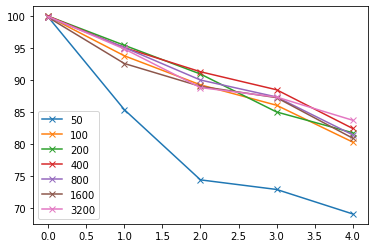

In [11]:
ss = [50,100,200,400,800,1600,3200]
for res,s in zip(results,ss):
    plt.plot(res,label=str(s),marker='x')
plt.legend()
plt.show()

In [53]:
lr = 1e-2 # size of step
resall = train_on_all( get_random_feature_model(),train_loaders_all,test_loaders_all,num_epochs=num_epochs)

Epoch [1/50], Loss: 0.0978
Epoch [2/50], Loss: 0.0493
Epoch [3/50], Loss: 0.0458
Epoch [4/50], Loss: 0.0428
Epoch [5/50], Loss: 0.0411
Epoch [6/50], Loss: 0.0372
Epoch [7/50], Loss: 0.0337
Epoch [8/50], Loss: 0.0311
Epoch [9/50], Loss: 0.0298
Epoch [10/50], Loss: 0.0269
Epoch [11/50], Loss: 0.0244
Epoch [12/50], Loss: 0.0221
Epoch [13/50], Loss: 0.0206
Epoch [14/50], Loss: 0.0182
Epoch [15/50], Loss: 0.0171
Epoch [16/50], Loss: 0.0147
Epoch [17/50], Loss: 0.0141
Epoch [18/50], Loss: 0.0133
Epoch [19/50], Loss: 0.0118
Epoch [20/50], Loss: 0.0107
Epoch [21/50], Loss: 0.0104
Epoch [22/50], Loss: 0.0090
Epoch [23/50], Loss: 0.0082
Epoch [24/50], Loss: 0.0075
Epoch [25/50], Loss: 0.0076
Epoch [26/50], Loss: 0.0071
Epoch [27/50], Loss: 0.0075
Epoch [28/50], Loss: 0.0063
Epoch [29/50], Loss: 0.0063
Epoch [30/50], Loss: 0.0062
Epoch [31/50], Loss: 0.0057
Epoch [32/50], Loss: 0.0057
Epoch [33/50], Loss: 0.0048
Epoch [34/50], Loss: 0.0049
Epoch [35/50], Loss: 0.0044
Epoch [36/50], Loss: 0.0055
E

In [55]:
resewc,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWC(lam=0.01),num_epochs=num_epochs )

EWC 0.01
Epoch [1/50], Loss: 0.0967
Epoch [2/50], Loss: 0.0494
Epoch [3/50], Loss: 0.0461
Epoch [4/50], Loss: 0.0428
Epoch [5/50], Loss: 0.0393
Epoch [6/50], Loss: 0.0377
Epoch [7/50], Loss: 0.0339
Epoch [8/50], Loss: 0.0314
Epoch [9/50], Loss: 0.0288
Epoch [10/50], Loss: 0.0264
Epoch [11/50], Loss: 0.0234
Epoch [12/50], Loss: 0.0221
Epoch [13/50], Loss: 0.0207
Epoch [14/50], Loss: 0.0179
Epoch [15/50], Loss: 0.0163
Epoch [16/50], Loss: 0.0154
Epoch [17/50], Loss: 0.0138
Epoch [18/50], Loss: 0.0127
Epoch [19/50], Loss: 0.0121
Epoch [20/50], Loss: 0.0103
Epoch [21/50], Loss: 0.0098
Epoch [22/50], Loss: 0.0089
Epoch [23/50], Loss: 0.0086
Epoch [24/50], Loss: 0.0080
Epoch [25/50], Loss: 0.0071
Epoch [26/50], Loss: 0.0069
Epoch [27/50], Loss: 0.0062
Epoch [28/50], Loss: 0.0063
Epoch [29/50], Loss: 0.0056
Epoch [30/50], Loss: 0.0052
Epoch [31/50], Loss: 0.0056
Epoch [32/50], Loss: 0.0051
Epoch [33/50], Loss: 0.0048
Epoch [34/50], Loss: 0.0049
Epoch [35/50], Loss: 0.0040
Epoch [36/50], Loss:

In [57]:
resewc2 = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWC(lam=0.001),num_epochs=num_epochs )

EWC 0.001
Epoch [1/50], Loss: 0.0967
Epoch [2/50], Loss: 0.0504
Epoch [3/50], Loss: 0.0469
Epoch [4/50], Loss: 0.0430
Epoch [5/50], Loss: 0.0398
Epoch [6/50], Loss: 0.0375
Epoch [7/50], Loss: 0.0339
Epoch [8/50], Loss: 0.0314
Epoch [9/50], Loss: 0.0283
Epoch [10/50], Loss: 0.0266
Epoch [11/50], Loss: 0.0237
Epoch [12/50], Loss: 0.0216
Epoch [13/50], Loss: 0.0203
Epoch [14/50], Loss: 0.0179
Epoch [15/50], Loss: 0.0160
Epoch [16/50], Loss: 0.0146
Epoch [17/50], Loss: 0.0136
Epoch [18/50], Loss: 0.0122
Epoch [19/50], Loss: 0.0117
Epoch [20/50], Loss: 0.0109
Epoch [21/50], Loss: 0.0100
Epoch [22/50], Loss: 0.0086
Epoch [23/50], Loss: 0.0082
Epoch [24/50], Loss: 0.0074
Epoch [25/50], Loss: 0.0073
Epoch [26/50], Loss: 0.0067
Epoch [27/50], Loss: 0.0067
Epoch [28/50], Loss: 0.0067
Epoch [29/50], Loss: 0.0057
Epoch [30/50], Loss: 0.0057
Epoch [31/50], Loss: 0.0058
Epoch [32/50], Loss: 0.0049
Epoch [33/50], Loss: 0.0047
Epoch [34/50], Loss: 0.0055
Epoch [35/50], Loss: 0.0046
Epoch [36/50], Loss

In [ ]:
resewc3 = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWC(lam=0.001),num_epochs=num_epochs )

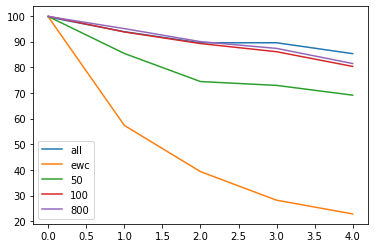

In [64]:
plt.plot(resall,label="all")
plt.plot(resewc,label="ewc")
plt.plot(results[0],label="50")
plt.plot(results[1],label="100")
plt.plot(results[4],label="800")
plt.legend()
plt.show()

In [ ]:
results = [resewc,resall,respp,resppbig,l2new]

def res_to_mtx(losses,filename):
    ks = [i for i in range(len(losses[0]))]
    A = [np.array(ks)]
    A += losses
    A = np.vstack( A ).T
    print(A.shape)
    np.savetxt(filename, A, delimiter=' ')

res_to_mtx(results,"MNIST_permutation_rand_feat.dat")

In [35]:
num_epochs = 100
lr = 5e-3 # size of step
results2 = []
inderrors = []
ss = [50,100,200,400,800,1600,3200,6400]
for s in ss:
    res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-5,s=s),num_epochs=num_epochs )
    results2 += [res]
    inderrors += [inds]

EWC++  50 1e-05
Epoch [1/100], Loss: 0.1052
Epoch [2/100], Loss: 0.0498
Epoch [3/100], Loss: 0.0478
Epoch [4/100], Loss: 0.0465
Epoch [5/100], Loss: 0.0441
Epoch [6/100], Loss: 0.0428
Epoch [7/100], Loss: 0.0412
Epoch [8/100], Loss: 0.0390
Epoch [9/100], Loss: 0.0375
Epoch [10/100], Loss: 0.0360
Epoch [11/100], Loss: 0.0334
Epoch [12/100], Loss: 0.0322
Epoch [13/100], Loss: 0.0305
Epoch [14/100], Loss: 0.0287
Epoch [15/100], Loss: 0.0273
Epoch [16/100], Loss: 0.0254
Epoch [17/100], Loss: 0.0241
Epoch [18/100], Loss: 0.0233
Epoch [19/100], Loss: 0.0217
Epoch [20/100], Loss: 0.0198
Epoch [21/100], Loss: 0.0189
Epoch [22/100], Loss: 0.0182
Epoch [23/100], Loss: 0.0168
Epoch [24/100], Loss: 0.0161
Epoch [25/100], Loss: 0.0148
Epoch [26/100], Loss: 0.0149
Epoch [27/100], Loss: 0.0135
Epoch [28/100], Loss: 0.0123
Epoch [29/100], Loss: 0.0122
Epoch [30/100], Loss: 0.0117
Epoch [31/100], Loss: 0.0109
Epoch [32/100], Loss: 0.0096
Epoch [33/100], Loss: 0.0100
Epoch [34/100], Loss: 0.0098
Epoch [

Epoch [66/100], Loss: 0.0420
Epoch [67/100], Loss: 0.0416
Epoch [68/100], Loss: 0.0413
Epoch [69/100], Loss: 0.0389
Epoch [70/100], Loss: 0.0408
Epoch [71/100], Loss: 0.0415
Epoch [72/100], Loss: 0.0379
Epoch [73/100], Loss: 0.0393
Epoch [74/100], Loss: 0.0379
Epoch [75/100], Loss: 0.0378
Epoch [76/100], Loss: 0.0377
Epoch [77/100], Loss: 0.0362
Epoch [78/100], Loss: 0.0381
Epoch [79/100], Loss: 0.0370
Epoch [80/100], Loss: 0.0379
Epoch [81/100], Loss: 0.0360
Epoch [82/100], Loss: 0.0339
Epoch [83/100], Loss: 0.0357
Epoch [84/100], Loss: 0.0345
Epoch [85/100], Loss: 0.0354
Epoch [86/100], Loss: 0.0351
Epoch [87/100], Loss: 0.0340
Epoch [88/100], Loss: 0.0334
Epoch [89/100], Loss: 0.0328
Epoch [90/100], Loss: 0.0345
Epoch [91/100], Loss: 0.0336
Epoch [92/100], Loss: 0.0331
Epoch [93/100], Loss: 0.0324
Epoch [94/100], Loss: 0.0324
Epoch [95/100], Loss: 0.0319
Epoch [96/100], Loss: 0.0305
Epoch [97/100], Loss: 0.0294
Epoch [98/100], Loss: 0.0314
Epoch [99/100], Loss: 0.0302
Epoch [100/100

Epoch [17/100], Loss: 0.0257
Epoch [18/100], Loss: 0.0235
Epoch [19/100], Loss: 0.0229
Epoch [20/100], Loss: 0.0212
Epoch [21/100], Loss: 0.0204
Epoch [22/100], Loss: 0.0188
Epoch [23/100], Loss: 0.0181
Epoch [24/100], Loss: 0.0169
Epoch [25/100], Loss: 0.0161
Epoch [26/100], Loss: 0.0152
Epoch [27/100], Loss: 0.0149
Epoch [28/100], Loss: 0.0143
Epoch [29/100], Loss: 0.0128
Epoch [30/100], Loss: 0.0131
Epoch [31/100], Loss: 0.0114
Epoch [32/100], Loss: 0.0115
Epoch [33/100], Loss: 0.0108
Epoch [34/100], Loss: 0.0094
Epoch [35/100], Loss: 0.0090
Epoch [36/100], Loss: 0.0087
Epoch [37/100], Loss: 0.0088
Epoch [38/100], Loss: 0.0085
Epoch [39/100], Loss: 0.0073
Epoch [40/100], Loss: 0.0069
Epoch [41/100], Loss: 0.0077
Epoch [42/100], Loss: 0.0060
Epoch [43/100], Loss: 0.0071
Epoch [44/100], Loss: 0.0075
Epoch [45/100], Loss: 0.0063
Epoch [46/100], Loss: 0.0061
Epoch [47/100], Loss: 0.0059
Epoch [48/100], Loss: 0.0063
Epoch [49/100], Loss: 0.0054
Epoch [50/100], Loss: 0.0057
Epoch [51/100]

Epoch [82/100], Loss: 0.0430
Epoch [83/100], Loss: 0.0447
Epoch [84/100], Loss: 0.0460
Epoch [85/100], Loss: 0.0429
Epoch [86/100], Loss: 0.0438
Epoch [87/100], Loss: 0.0422
Epoch [88/100], Loss: 0.0425
Epoch [89/100], Loss: 0.0416
Epoch [90/100], Loss: 0.0422
Epoch [91/100], Loss: 0.0409
Epoch [92/100], Loss: 0.0403
Epoch [93/100], Loss: 0.0420
Epoch [94/100], Loss: 0.0394
Epoch [95/100], Loss: 0.0416
Epoch [96/100], Loss: 0.0399
Epoch [97/100], Loss: 0.0402
Epoch [98/100], Loss: 0.0377
Epoch [99/100], Loss: 0.0403
Epoch [100/100], Loss: 0.0384
update data..
task data norm and number entries: tensor(425.4097, device='cuda:0') torch.Size([100, 31370])
..done
test performance :  [99.71630859 94.41054535 89.43772125  0.          0.        ]
individual errors:  [array(96.97399, dtype=float32), array(79.8237, dtype=float32), array(91.51547, dtype=float32)]
Epoch [1/100], Loss: 0.1529
Epoch [2/100], Loss: 0.1362
Epoch [3/100], Loss: 0.1296
Epoch [4/100], Loss: 0.1290
Epoch [5/100], Loss: 0.

Epoch [33/100], Loss: 0.0096
Epoch [34/100], Loss: 0.0093
Epoch [35/100], Loss: 0.0087
Epoch [36/100], Loss: 0.0088
Epoch [37/100], Loss: 0.0083
Epoch [38/100], Loss: 0.0078
Epoch [39/100], Loss: 0.0079
Epoch [40/100], Loss: 0.0077
Epoch [41/100], Loss: 0.0070
Epoch [42/100], Loss: 0.0065
Epoch [43/100], Loss: 0.0059
Epoch [44/100], Loss: 0.0058
Epoch [45/100], Loss: 0.0062
Epoch [46/100], Loss: 0.0057
Epoch [47/100], Loss: 0.0064
Epoch [48/100], Loss: 0.0058
Epoch [49/100], Loss: 0.0058
Epoch [50/100], Loss: 0.0059
Epoch [51/100], Loss: 0.0053
Epoch [52/100], Loss: 0.0049
Epoch [53/100], Loss: 0.0049
Epoch [54/100], Loss: 0.0045
Epoch [55/100], Loss: 0.0045
Epoch [56/100], Loss: 0.0051
Epoch [57/100], Loss: 0.0052
Epoch [58/100], Loss: 0.0044
Epoch [59/100], Loss: 0.0045
Epoch [60/100], Loss: 0.0042
Epoch [61/100], Loss: 0.0047
Epoch [62/100], Loss: 0.0045
Epoch [63/100], Loss: 0.0035
Epoch [64/100], Loss: 0.0042
Epoch [65/100], Loss: 0.0045
Epoch [66/100], Loss: 0.0043
Epoch [67/100]

Epoch [98/100], Loss: 0.0462
Epoch [99/100], Loss: 0.0464
Epoch [100/100], Loss: 0.0466
update data..
task data norm and number entries: tensor(439.1483, device='cuda:0') torch.Size([200, 31370])
..done
test performance :  [99.57447052 93.77053833 88.57010651  0.          0.        ]
individual errors:  [array(96.26478, dtype=float32), array(84.28011, dtype=float32), array(85.16542, dtype=float32)]
Epoch [1/100], Loss: 0.1443
Epoch [2/100], Loss: 0.1264
Epoch [3/100], Loss: 0.1240
Epoch [4/100], Loss: 0.1218
Epoch [5/100], Loss: 0.1200
Epoch [6/100], Loss: 0.1193
Epoch [7/100], Loss: 0.1176
Epoch [8/100], Loss: 0.1147
Epoch [9/100], Loss: 0.1136
Epoch [10/100], Loss: 0.1122
Epoch [11/100], Loss: 0.1100
Epoch [12/100], Loss: 0.1079
Epoch [13/100], Loss: 0.1067
Epoch [14/100], Loss: 0.1037
Epoch [15/100], Loss: 0.1027
Epoch [16/100], Loss: 0.1004
Epoch [17/100], Loss: 0.0992
Epoch [18/100], Loss: 0.0985
Epoch [19/100], Loss: 0.0959
Epoch [20/100], Loss: 0.0957
Epoch [21/100], Loss: 0.093

Epoch [49/100], Loss: 0.0058
Epoch [50/100], Loss: 0.0052
Epoch [51/100], Loss: 0.0065
Epoch [52/100], Loss: 0.0058
Epoch [53/100], Loss: 0.0054
Epoch [54/100], Loss: 0.0059
Epoch [55/100], Loss: 0.0062
Epoch [56/100], Loss: 0.0055
Epoch [57/100], Loss: 0.0049
Epoch [58/100], Loss: 0.0052
Epoch [59/100], Loss: 0.0054
Epoch [60/100], Loss: 0.0049
Epoch [61/100], Loss: 0.0056
Epoch [62/100], Loss: 0.0050
Epoch [63/100], Loss: 0.0040
Epoch [64/100], Loss: 0.0050
Epoch [65/100], Loss: 0.0044
Epoch [66/100], Loss: 0.0046
Epoch [67/100], Loss: 0.0045
Epoch [68/100], Loss: 0.0046
Epoch [69/100], Loss: 0.0043
Epoch [70/100], Loss: 0.0048
Epoch [71/100], Loss: 0.0044
Epoch [72/100], Loss: 0.0046
Epoch [73/100], Loss: 0.0046
Epoch [74/100], Loss: 0.0044
Epoch [75/100], Loss: 0.0046
Epoch [76/100], Loss: 0.0041
Epoch [77/100], Loss: 0.0036
Epoch [78/100], Loss: 0.0041
Epoch [79/100], Loss: 0.0037
Epoch [80/100], Loss: 0.0048
Epoch [81/100], Loss: 0.0041
Epoch [82/100], Loss: 0.0047
Epoch [83/100]

Epoch [3/100], Loss: 0.1226
Epoch [4/100], Loss: 0.1198
Epoch [5/100], Loss: 0.1181
Epoch [6/100], Loss: 0.1174
Epoch [7/100], Loss: 0.1159
Epoch [8/100], Loss: 0.1131
Epoch [9/100], Loss: 0.1116
Epoch [10/100], Loss: 0.1095
Epoch [11/100], Loss: 0.1082
Epoch [12/100], Loss: 0.1062
Epoch [13/100], Loss: 0.1043
Epoch [14/100], Loss: 0.1029
Epoch [15/100], Loss: 0.1009
Epoch [16/100], Loss: 0.0995
Epoch [17/100], Loss: 0.0982
Epoch [18/100], Loss: 0.0960
Epoch [19/100], Loss: 0.0946
Epoch [20/100], Loss: 0.0936
Epoch [21/100], Loss: 0.0925
Epoch [22/100], Loss: 0.0894
Epoch [23/100], Loss: 0.0892
Epoch [24/100], Loss: 0.0879
Epoch [25/100], Loss: 0.0860
Epoch [26/100], Loss: 0.0854
Epoch [27/100], Loss: 0.0846
Epoch [28/100], Loss: 0.0821
Epoch [29/100], Loss: 0.0812
Epoch [30/100], Loss: 0.0795
Epoch [31/100], Loss: 0.0809
Epoch [32/100], Loss: 0.0779
Epoch [33/100], Loss: 0.0765
Epoch [34/100], Loss: 0.0762
Epoch [35/100], Loss: 0.0753
Epoch [36/100], Loss: 0.0753
Epoch [37/100], Loss:

Epoch [65/100], Loss: 0.0046
Epoch [66/100], Loss: 0.0045
Epoch [67/100], Loss: 0.0048
Epoch [68/100], Loss: 0.0042
Epoch [69/100], Loss: 0.0048
Epoch [70/100], Loss: 0.0041
Epoch [71/100], Loss: 0.0043
Epoch [72/100], Loss: 0.0042
Epoch [73/100], Loss: 0.0035
Epoch [74/100], Loss: 0.0045
Epoch [75/100], Loss: 0.0039
Epoch [76/100], Loss: 0.0038
Epoch [77/100], Loss: 0.0038
Epoch [78/100], Loss: 0.0043
Epoch [79/100], Loss: 0.0045
Epoch [80/100], Loss: 0.0045
Epoch [81/100], Loss: 0.0045
Epoch [82/100], Loss: 0.0046
Epoch [83/100], Loss: 0.0043
Epoch [84/100], Loss: 0.0045
Epoch [85/100], Loss: 0.0043
Epoch [86/100], Loss: 0.0041
Epoch [87/100], Loss: 0.0036
Epoch [88/100], Loss: 0.0041
Epoch [89/100], Loss: 0.0043
Epoch [90/100], Loss: 0.0040
Epoch [91/100], Loss: 0.0039
Epoch [92/100], Loss: 0.0040
Epoch [93/100], Loss: 0.0043
Epoch [94/100], Loss: 0.0040
Epoch [95/100], Loss: 0.0039
Epoch [96/100], Loss: 0.0039
Epoch [97/100], Loss: 0.0040
Epoch [98/100], Loss: 0.0033
Epoch [99/100]

Epoch [19/100], Loss: 0.0929
Epoch [20/100], Loss: 0.0916
Epoch [21/100], Loss: 0.0899
Epoch [22/100], Loss: 0.0901
Epoch [23/100], Loss: 0.0874
Epoch [24/100], Loss: 0.0877
Epoch [25/100], Loss: 0.0834
Epoch [26/100], Loss: 0.0829
Epoch [27/100], Loss: 0.0832
Epoch [28/100], Loss: 0.0814
Epoch [29/100], Loss: 0.0800
Epoch [30/100], Loss: 0.0816
Epoch [31/100], Loss: 0.0790
Epoch [32/100], Loss: 0.0782
Epoch [33/100], Loss: 0.0779
Epoch [34/100], Loss: 0.0771
Epoch [35/100], Loss: 0.0770
Epoch [36/100], Loss: 0.0747
Epoch [37/100], Loss: 0.0736
Epoch [38/100], Loss: 0.0732
Epoch [39/100], Loss: 0.0733
Epoch [40/100], Loss: 0.0713
Epoch [41/100], Loss: 0.0699
Epoch [42/100], Loss: 0.0704
Epoch [43/100], Loss: 0.0703
Epoch [44/100], Loss: 0.0686
Epoch [45/100], Loss: 0.0697
Epoch [46/100], Loss: 0.0679
Epoch [47/100], Loss: 0.0675
Epoch [48/100], Loss: 0.0666
Epoch [49/100], Loss: 0.0666
Epoch [50/100], Loss: 0.0655
Epoch [51/100], Loss: 0.0664
Epoch [52/100], Loss: 0.0635
Epoch [53/100]

Epoch [81/100], Loss: 0.0036
Epoch [82/100], Loss: 0.0041
Epoch [83/100], Loss: 0.0041
Epoch [84/100], Loss: 0.0039
Epoch [85/100], Loss: 0.0036
Epoch [86/100], Loss: 0.0039
Epoch [87/100], Loss: 0.0036
Epoch [88/100], Loss: 0.0039
Epoch [89/100], Loss: 0.0040
Epoch [90/100], Loss: 0.0036
Epoch [91/100], Loss: 0.0034
Epoch [92/100], Loss: 0.0036
Epoch [93/100], Loss: 0.0038
Epoch [94/100], Loss: 0.0038
Epoch [95/100], Loss: 0.0033
Epoch [96/100], Loss: 0.0037
Epoch [97/100], Loss: 0.0041
Epoch [98/100], Loss: 0.0036
Epoch [99/100], Loss: 0.0036
Epoch [100/100], Loss: 0.0029
generate task data..
task data norm and number entries: tensor(460.1783, device='cuda:0') torch.Size([1600, 31370])
..done
test performance :  [99.76359558  0.          0.          0.          0.        ]
individual errors:  [array(99.763596, dtype=float32)]
Epoch [1/100], Loss: 0.1548
Epoch [2/100], Loss: 0.1120
Epoch [3/100], Loss: 0.1094
Epoch [4/100], Loss: 0.1081
Epoch [5/100], Loss: 0.1063
Epoch [6/100], Loss:

Epoch [35/100], Loss: 0.0743
Epoch [36/100], Loss: 0.0743
Epoch [37/100], Loss: 0.0731
Epoch [38/100], Loss: 0.0727
Epoch [39/100], Loss: 0.0733
Epoch [40/100], Loss: 0.0724
Epoch [41/100], Loss: 0.0715
Epoch [42/100], Loss: 0.0688
Epoch [43/100], Loss: 0.0683
Epoch [44/100], Loss: 0.0691
Epoch [45/100], Loss: 0.0685
Epoch [46/100], Loss: 0.0682
Epoch [47/100], Loss: 0.0685
Epoch [48/100], Loss: 0.0674
Epoch [49/100], Loss: 0.0653
Epoch [50/100], Loss: 0.0648
Epoch [51/100], Loss: 0.0639
Epoch [52/100], Loss: 0.0658
Epoch [53/100], Loss: 0.0645
Epoch [54/100], Loss: 0.0649
Epoch [55/100], Loss: 0.0636
Epoch [56/100], Loss: 0.0620
Epoch [57/100], Loss: 0.0620
Epoch [58/100], Loss: 0.0612
Epoch [59/100], Loss: 0.0613
Epoch [60/100], Loss: 0.0619
Epoch [61/100], Loss: 0.0593
Epoch [62/100], Loss: 0.0606
Epoch [63/100], Loss: 0.0602
Epoch [64/100], Loss: 0.0604
Epoch [65/100], Loss: 0.0585
Epoch [66/100], Loss: 0.0598
Epoch [67/100], Loss: 0.0592
Epoch [68/100], Loss: 0.0589
Epoch [69/100]

Epoch [97/100], Loss: 0.0033
Epoch [98/100], Loss: 0.0039
Epoch [99/100], Loss: 0.0040
Epoch [100/100], Loss: 0.0037
generate task data..
task data norm and number entries: tensor(463.0654, device='cuda:0') torch.Size([3200, 31370])
..done
test performance :  [99.71630859  0.          0.          0.          0.        ]
individual errors:  [array(99.71631, dtype=float32)]
Epoch [1/100], Loss: 0.1562
Epoch [2/100], Loss: 0.1130
Epoch [3/100], Loss: 0.1105
Epoch [4/100], Loss: 0.1086
Epoch [5/100], Loss: 0.1087
Epoch [6/100], Loss: 0.1062
Epoch [7/100], Loss: 0.1042
Epoch [8/100], Loss: 0.1016
Epoch [9/100], Loss: 0.1009
Epoch [10/100], Loss: 0.0992
Epoch [11/100], Loss: 0.0964
Epoch [12/100], Loss: 0.0950
Epoch [13/100], Loss: 0.0935
Epoch [14/100], Loss: 0.0911
Epoch [15/100], Loss: 0.0888
Epoch [16/100], Loss: 0.0876
Epoch [17/100], Loss: 0.0877
Epoch [18/100], Loss: 0.0854
Epoch [19/100], Loss: 0.0829
Epoch [20/100], Loss: 0.0816
Epoch [21/100], Loss: 0.0793
Epoch [22/100], Loss: 0.0

Epoch [51/100], Loss: 0.0666
Epoch [52/100], Loss: 0.0658
Epoch [53/100], Loss: 0.0647
Epoch [54/100], Loss: 0.0644
Epoch [55/100], Loss: 0.0620
Epoch [56/100], Loss: 0.0642
Epoch [57/100], Loss: 0.0633
Epoch [58/100], Loss: 0.0638
Epoch [59/100], Loss: 0.0638
Epoch [60/100], Loss: 0.0623
Epoch [61/100], Loss: 0.0606
Epoch [62/100], Loss: 0.0602
Epoch [63/100], Loss: 0.0607
Epoch [64/100], Loss: 0.0597
Epoch [65/100], Loss: 0.0611
Epoch [66/100], Loss: 0.0607
Epoch [67/100], Loss: 0.0598
Epoch [68/100], Loss: 0.0584
Epoch [69/100], Loss: 0.0610
Epoch [70/100], Loss: 0.0587
Epoch [71/100], Loss: 0.0597
Epoch [72/100], Loss: 0.0596
Epoch [73/100], Loss: 0.0590
Epoch [74/100], Loss: 0.0590
Epoch [75/100], Loss: 0.0573
Epoch [76/100], Loss: 0.0584
Epoch [77/100], Loss: 0.0577
Epoch [78/100], Loss: 0.0568
Epoch [79/100], Loss: 0.0570
Epoch [80/100], Loss: 0.0571
Epoch [81/100], Loss: 0.0577
Epoch [82/100], Loss: 0.0570
Epoch [83/100], Loss: 0.0569
Epoch [84/100], Loss: 0.0560
Epoch [85/100]

Epoch [4/100], Loss: 0.1086
Epoch [5/100], Loss: 0.1079
Epoch [6/100], Loss: 0.1064
Epoch [7/100], Loss: 0.1043
Epoch [8/100], Loss: 0.1025
Epoch [9/100], Loss: 0.1011
Epoch [10/100], Loss: 0.0995
Epoch [11/100], Loss: 0.0975
Epoch [12/100], Loss: 0.0961
Epoch [13/100], Loss: 0.0943
Epoch [14/100], Loss: 0.0928
Epoch [15/100], Loss: 0.0910
Epoch [16/100], Loss: 0.0894
Epoch [17/100], Loss: 0.0878
Epoch [18/100], Loss: 0.0865
Epoch [19/100], Loss: 0.0846
Epoch [20/100], Loss: 0.0830
Epoch [21/100], Loss: 0.0823
Epoch [22/100], Loss: 0.0800
Epoch [23/100], Loss: 0.0781
Epoch [24/100], Loss: 0.0769
Epoch [25/100], Loss: 0.0772
Epoch [26/100], Loss: 0.0745
Epoch [27/100], Loss: 0.0740
Epoch [28/100], Loss: 0.0727
Epoch [29/100], Loss: 0.0719
Epoch [30/100], Loss: 0.0683
Epoch [31/100], Loss: 0.0690
Epoch [32/100], Loss: 0.0671
Epoch [33/100], Loss: 0.0666
Epoch [34/100], Loss: 0.0646
Epoch [35/100], Loss: 0.0657
Epoch [36/100], Loss: 0.0635
Epoch [37/100], Loss: 0.0623
Epoch [38/100], Loss

Epoch [67/100], Loss: 0.0606
Epoch [68/100], Loss: 0.0595
Epoch [69/100], Loss: 0.0572
Epoch [70/100], Loss: 0.0596
Epoch [71/100], Loss: 0.0584
Epoch [72/100], Loss: 0.0577
Epoch [73/100], Loss: 0.0567
Epoch [74/100], Loss: 0.0561
Epoch [75/100], Loss: 0.0571
Epoch [76/100], Loss: 0.0558
Epoch [77/100], Loss: 0.0555
Epoch [78/100], Loss: 0.0562
Epoch [79/100], Loss: 0.0571
Epoch [80/100], Loss: 0.0562
Epoch [81/100], Loss: 0.0579
Epoch [82/100], Loss: 0.0568
Epoch [83/100], Loss: 0.0542
Epoch [84/100], Loss: 0.0554
Epoch [85/100], Loss: 0.0558
Epoch [86/100], Loss: 0.0545
Epoch [87/100], Loss: 0.0551
Epoch [88/100], Loss: 0.0566
Epoch [89/100], Loss: 0.0551
Epoch [90/100], Loss: 0.0563
Epoch [91/100], Loss: 0.0579
Epoch [92/100], Loss: 0.0549
Epoch [93/100], Loss: 0.0537
Epoch [94/100], Loss: 0.0554
Epoch [95/100], Loss: 0.0534
Epoch [96/100], Loss: 0.0559
Epoch [97/100], Loss: 0.0552
Epoch [98/100], Loss: 0.0547
Epoch [99/100], Loss: 0.0543
Epoch [100/100], Loss: 0.0543
update data..

In [ ]:
50, 5e-3, lam 5e-6 [99.71630859 86.61508942 64.12440491 56.21234894 54.12968445] 

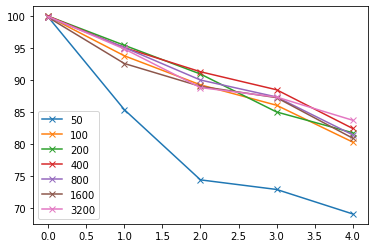

In [36]:
ss = [50,100,200,400,800,1600,3200,6400]
for res,s in zip(results,ss):
    plt.plot(res,label=str(s),marker='x')
plt.legend()
plt.show()

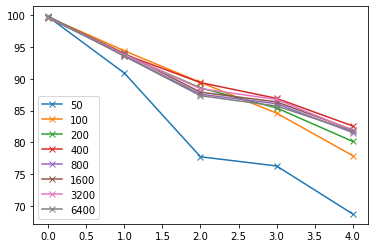

In [37]:
ss = [50,100,200,400,800,1600,3200,6400]
for res,s in zip(results2,ss):
    plt.plot(res,label=str(s),marker='x')
plt.legend()
plt.show()

In [38]:
num_epochs = 50
lr = 5e-2 # size of step
results3 = []
inderrors3 = []
ss = [800]
for s in ss:
    res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-5,s=s),num_epochs=num_epochs )
    results3 += [res]
    inderrors3 += [inds]

EWC++  800 1e-05
Epoch [1/50], Loss: 0.1005
Epoch [2/50], Loss: 0.0635
Epoch [3/50], Loss: 0.0424
Epoch [4/50], Loss: 0.0328
Epoch [5/50], Loss: 0.0272
Epoch [6/50], Loss: 0.0218
Epoch [7/50], Loss: 0.0180
Epoch [8/50], Loss: 0.0138
Epoch [9/50], Loss: 0.0117
Epoch [10/50], Loss: 0.0099
Epoch [11/50], Loss: 0.0072
Epoch [12/50], Loss: 0.0065
Epoch [13/50], Loss: 0.0059
Epoch [14/50], Loss: 0.0058
Epoch [15/50], Loss: 0.0051
Epoch [16/50], Loss: 0.0048
Epoch [17/50], Loss: 0.0042
Epoch [18/50], Loss: 0.0044
Epoch [19/50], Loss: 0.0048
Epoch [20/50], Loss: 0.0054
Epoch [21/50], Loss: 0.0046
Epoch [22/50], Loss: 0.0037
Epoch [23/50], Loss: 0.0045
Epoch [24/50], Loss: 0.0040
Epoch [25/50], Loss: 0.0041
Epoch [26/50], Loss: 0.0040
Epoch [27/50], Loss: 0.0044
Epoch [28/50], Loss: 0.0052
Epoch [29/50], Loss: 0.0040
Epoch [30/50], Loss: 0.0036
Epoch [31/50], Loss: 0.0038
Epoch [32/50], Loss: 0.0038
Epoch [33/50], Loss: 0.0039
Epoch [34/50], Loss: 0.0033
Epoch [35/50], Loss: 0.0033
Epoch [36/50

In [40]:
num_epochs = 50
lr = 5e-2 # size of step
res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-5,s=6*784),num_epochs=num_epochs )


EWC++  4704 1e-05
Epoch [1/50], Loss: 0.0966
Epoch [2/50], Loss: 0.0592
Epoch [3/50], Loss: 0.0418
Epoch [4/50], Loss: 0.0299
Epoch [5/50], Loss: 0.0238
Epoch [6/50], Loss: 0.0182
Epoch [7/50], Loss: 0.0137
Epoch [8/50], Loss: 0.0114
Epoch [9/50], Loss: 0.0089
Epoch [10/50], Loss: 0.0073
Epoch [11/50], Loss: 0.0055
Epoch [12/50], Loss: 0.0055
Epoch [13/50], Loss: 0.0049
Epoch [14/50], Loss: 0.0049
Epoch [15/50], Loss: 0.0046
Epoch [16/50], Loss: 0.0049
Epoch [17/50], Loss: 0.0041
Epoch [18/50], Loss: 0.0046
Epoch [19/50], Loss: 0.0036
Epoch [20/50], Loss: 0.0048
Epoch [21/50], Loss: 0.0041
Epoch [22/50], Loss: 0.0041
Epoch [23/50], Loss: 0.0038
Epoch [24/50], Loss: 0.0038
Epoch [25/50], Loss: 0.0041
Epoch [26/50], Loss: 0.0034
Epoch [27/50], Loss: 0.0036
Epoch [28/50], Loss: 0.0034
Epoch [29/50], Loss: 0.0033
Epoch [30/50], Loss: 0.0038
Epoch [31/50], Loss: 0.0033
Epoch [32/50], Loss: 0.0030
Epoch [33/50], Loss: 0.0033
Epoch [34/50], Loss: 0.0043
Epoch [35/50], Loss: 0.0031
Epoch [36/5

In [47]:
num_epochs = 50
lr = 1e-2 # size of step
res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-6,s=6*784),num_epochs=num_epochs )


EWC++  4704 1e-06
Epoch [1/50], Loss: 0.0979
Epoch [2/50], Loss: 0.0904
Epoch [3/50], Loss: 0.0841
Epoch [4/50], Loss: 0.0788
Epoch [5/50], Loss: 0.0742
Epoch [6/50], Loss: 0.0705
Epoch [7/50], Loss: 0.0672
Epoch [8/50], Loss: 0.0645
Epoch [9/50], Loss: 0.0624
Epoch [10/50], Loss: 0.0605
Epoch [11/50], Loss: 0.0587
Epoch [12/50], Loss: 0.0574
Epoch [13/50], Loss: 0.0563
Epoch [14/50], Loss: 0.0552
Epoch [15/50], Loss: 0.0541
Epoch [16/50], Loss: 0.0538
Epoch [17/50], Loss: 0.0528
Epoch [18/50], Loss: 0.0524
Epoch [19/50], Loss: 0.0522
Epoch [20/50], Loss: 0.0516
Epoch [21/50], Loss: 0.0513
Epoch [22/50], Loss: 0.0513
Epoch [23/50], Loss: 0.0510
Epoch [24/50], Loss: 0.0507
Epoch [25/50], Loss: 0.0507
Epoch [26/50], Loss: 0.0506
Epoch [27/50], Loss: 0.0502
Epoch [28/50], Loss: 0.0502
Epoch [29/50], Loss: 0.0502
Epoch [30/50], Loss: 0.0504
Epoch [31/50], Loss: 0.0500
Epoch [32/50], Loss: 0.0500
Epoch [33/50], Loss: 0.0498
Epoch [34/50], Loss: 0.0497
Epoch [35/50], Loss: 0.0498
Epoch [36/5

In [48]:
num_epochs = 50
lr = 1e-3 # size of step
res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-6,s=6*784),num_epochs=num_epochs )


EWC++  4704 1e-06
Epoch [1/50], Loss: 0.1004
Epoch [2/50], Loss: 0.0996
Epoch [3/50], Loss: 0.0988
Epoch [4/50], Loss: 0.0980
Epoch [5/50], Loss: 0.0971
Epoch [6/50], Loss: 0.0964
Epoch [7/50], Loss: 0.0957
Epoch [8/50], Loss: 0.0949
Epoch [9/50], Loss: 0.0941
Epoch [10/50], Loss: 0.0934
Epoch [11/50], Loss: 0.0927
Epoch [12/50], Loss: 0.0919
Epoch [13/50], Loss: 0.0912
Epoch [14/50], Loss: 0.0906
Epoch [15/50], Loss: 0.0899
Epoch [16/50], Loss: 0.0892
Epoch [17/50], Loss: 0.0886
Epoch [18/50], Loss: 0.0879
Epoch [19/50], Loss: 0.0873
Epoch [20/50], Loss: 0.0867
Epoch [21/50], Loss: 0.0861
Epoch [22/50], Loss: 0.0855
Epoch [23/50], Loss: 0.0849
Epoch [24/50], Loss: 0.0843
Epoch [25/50], Loss: 0.0837
Epoch [26/50], Loss: 0.0832
Epoch [27/50], Loss: 0.0826
Epoch [28/50], Loss: 0.0820
Epoch [29/50], Loss: 0.0816
Epoch [30/50], Loss: 0.0810
Epoch [31/50], Loss: 0.0806
Epoch [32/50], Loss: 0.0800
Epoch [33/50], Loss: 0.0796
Epoch [34/50], Loss: 0.0790
Epoch [35/50], Loss: 0.0786
Epoch [36/5

In [50]:
num_epochs = 50
lr = 1e-4 # size of step
res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-6,s=6*784),num_epochs=num_epochs )


EWC++  4704 1e-06
Epoch [1/50], Loss: 0.0983
Epoch [2/50], Loss: 0.0849
Epoch [3/50], Loss: 0.0743
Epoch [4/50], Loss: 0.0664
Epoch [5/50], Loss: 0.0607
Epoch [6/50], Loss: 0.0566
Epoch [7/50], Loss: 0.0540
Epoch [8/50], Loss: 0.0523
Epoch [9/50], Loss: 0.0514
Epoch [10/50], Loss: 0.0505
Epoch [11/50], Loss: 0.0500
Epoch [12/50], Loss: 0.0500
Epoch [13/50], Loss: 0.0500
Epoch [14/50], Loss: 0.0497
Epoch [15/50], Loss: 0.0497
Epoch [16/50], Loss: 0.0496
Epoch [17/50], Loss: 0.0494
Epoch [18/50], Loss: 0.0496
Epoch [19/50], Loss: 0.0497
Epoch [20/50], Loss: 0.0494
Epoch [21/50], Loss: 0.0500
Epoch [22/50], Loss: 0.0496
Epoch [23/50], Loss: 0.0500
Epoch [24/50], Loss: 0.0493
Epoch [25/50], Loss: 0.0495
Epoch [26/50], Loss: 0.0493
Epoch [27/50], Loss: 0.0489
Epoch [28/50], Loss: 0.0493
Epoch [29/50], Loss: 0.0491
Epoch [30/50], Loss: 0.0491
Epoch [31/50], Loss: 0.0489
Epoch [32/50], Loss: 0.0492
Epoch [33/50], Loss: 0.0489
Epoch [34/50], Loss: 0.0492
Epoch [35/50], Loss: 0.0490
Epoch [36/5

In [52]:
num_epochs = 50
lr = 5e-3 # size of step
res,inds = run_simulation( get_random_feature_model(),train_loaders,test_loaders,EWCplusplus(lam=1e-6,s=6*784),num_epochs=num_epochs )


EWC++  4704 1e-06
Epoch [1/50], Loss: 0.0993
Epoch [2/50], Loss: 0.0498
Epoch [3/50], Loss: 0.0478
Epoch [4/50], Loss: 0.0463
Epoch [5/50], Loss: 0.0448
Epoch [6/50], Loss: 0.0428
Epoch [7/50], Loss: 0.0406
Epoch [8/50], Loss: 0.0393
Epoch [9/50], Loss: 0.0371
Epoch [10/50], Loss: 0.0356
Epoch [11/50], Loss: 0.0336
Epoch [12/50], Loss: 0.0319
Epoch [13/50], Loss: 0.0299
Epoch [14/50], Loss: 0.0289
Epoch [15/50], Loss: 0.0270
Epoch [16/50], Loss: 0.0250
Epoch [17/50], Loss: 0.0237
Epoch [18/50], Loss: 0.0228
Epoch [19/50], Loss: 0.0209
Epoch [20/50], Loss: 0.0195
Epoch [21/50], Loss: 0.0193
Epoch [22/50], Loss: 0.0173
Epoch [23/50], Loss: 0.0173
Epoch [24/50], Loss: 0.0164
Epoch [25/50], Loss: 0.0153
Epoch [26/50], Loss: 0.0147
Epoch [27/50], Loss: 0.0137
Epoch [28/50], Loss: 0.0127
Epoch [29/50], Loss: 0.0112
Epoch [30/50], Loss: 0.0107
Epoch [31/50], Loss: 0.0106
Epoch [32/50], Loss: 0.0104
Epoch [33/50], Loss: 0.0096
Epoch [34/50], Loss: 0.0095
Epoch [35/50], Loss: 0.0083
Epoch [36/5